# Imports and Functions

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
from datetime import datetime, time
from IPython.display import display
pd.set_option("display.max_columns",50)
pd.options.mode.chained_assignment = None  # default='warn'

import sys
sys.path.append("/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data")
from apple_watch_data_package.Data import preprocess, get_daily_heartrate_stats, get_heartrate_data, get_workouts

In [4]:
path = "apple_health_export_2022-12-10.csv"
data = pd.read_csv(path,nrows=100000).query("sourceName=='Lasse’s Apple\xa0Watch'")

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_36577/474158819.py:2: DtypeWarning: Columns (28,33,40,42,43,49,50,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path,nrows=100000).query("sourceName=='Lasse’s Apple\xa0Watch'")


In [5]:
pp = preprocess(data)

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/apple_watch_data_package/Data.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return data
30it [00:00, 73.15it/s]


In [12]:
pp.type.value_counts()

ActiveEnergyBurned            32664
BasalEnergyBurned             23098
HeartRate                     17219
DistanceWalkingRunning        14790
StepCount                      3289
DistanceCycling                1954
AppleExerciseTime              1134
AppleStandTime                  972
RunningSpeed                    540
RunningPower                    484
AppleStandHour                  306
RunningVerticalOscillation      237
RunningStrideLength             236
RunningGroundContactTime        225
OxygenSaturation                105
HeartRateVariabilitySDNN         92
FlightsClimbed                   55
RespiratoryRate                  43
StairDescentSpeed                42
StairAscentSpeed                 42
SleepAnalysis                    27
VO2Max                           26
RestingHeartRate                 23
WalkingHeartRateAverage          19
HeartRateRecoveryOneMinute        2
Name: type, dtype: int64

### Daily Heart Rate Analysis

In [137]:
hr = get_heartrate_data(pp)

Text(0.5, 1.0, 'Time watch is put on')

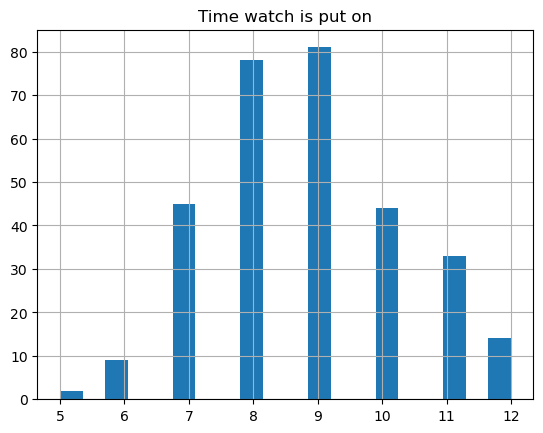

In [246]:
hr.loc[hr["first_on_wrist"],"Hour"].hist(bins=20)
plt.title("Time watch is put on")
plt.show()

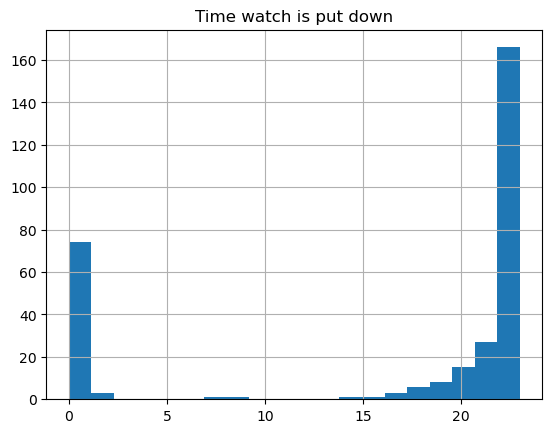

In [247]:
hr.loc[hr["last_on_wrist"].fillna(False),"Hour"].hist(bins=20)
plt.title("Time watch is put down")
plt.show()

In [230]:
daily = get_daily_heartrate_stats(pp)

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/apple_watch_data_package/Data.py:134: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  .join(data[(data["type"]=="HeartRate") & (data["workout"]!=True)]
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/apple_watch_data_package/Data.py:130: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  daily = (hr[hr["first_on_wrist"]]


In [248]:
daily.head()

,first_on_wrist,off_wrist,last_on_wrist,min_Heartrate,max_Heartrate_leisure,var_Heartrate_leisure,max_HeartRate,var_HeartRate,RestingHeartRate,identifier,duration
date,,,,,,,,,,,
2021-12-26,09:32:23,10.617500,NaN,49.0,113.0,211.363801,168.584,288.225790,55.0,1.0,24.706995
2021-12-27,10:17:42,9.812222,23:33:14,54.0,140.0,440.997939,156.997,486.191344,57.0,3.0,40.640777
2021-12-28,09:11:02,9.630000,NaN,50.0,98.0,84.551173,98.000,87.649949,55.0,1.0,17.424708
2021-12-29,12:18:20,10.646944,23:21:21,60.0,107.0,90.657169,107.000,90.657169,63.0,NaN,NaN
2021-12-30,10:13:01,10.861111,23:44:10,54.0,107.0,147.613751,107.000,157.336069,59.0,1.0,77.231020


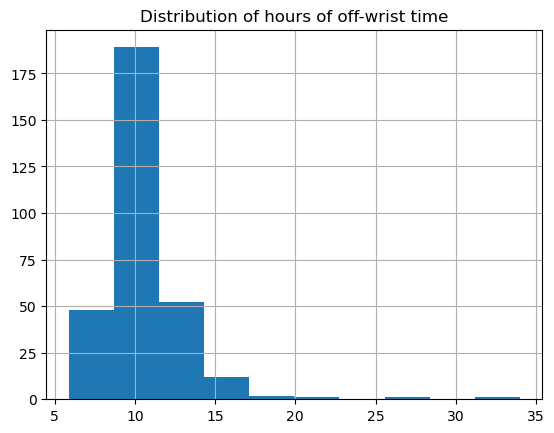

In [250]:
daily["off_wrist"].hist()
plt.title("Distribution of hours of off-wrist time")
plt.show()

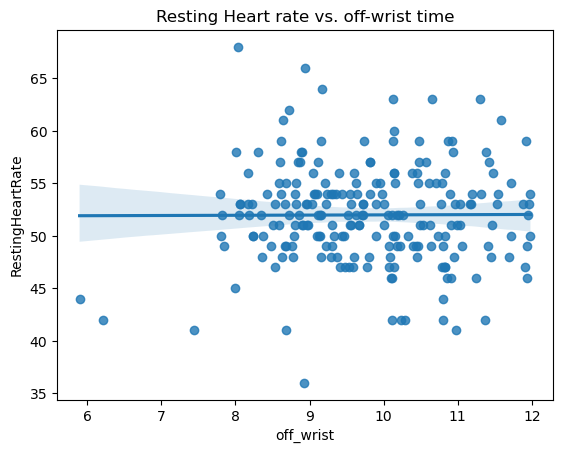

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(daily.query("off_wrist<=12"),x="off_wrist",y="RestingHeartRate")
plt.title("Resting Heart rate vs. off-wrist time")
plt.show()


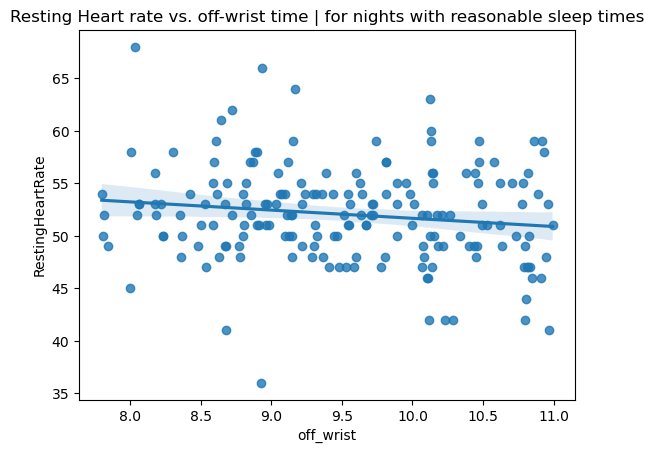

In [252]:
# Closing in on normal sleep times:
subset = daily[(daily["first_on_wrist"]>time(6)) & (daily["first_on_wrist"]<time(12)) & (daily["off_wrist"]<11) & (daily["off_wrist"]>7)]
sns.regplot(subset,x="off_wrist",y="RestingHeartRate")
plt.title("Resting Heart rate vs. off-wrist time | for nights with reasonable sleep times")
plt.show()

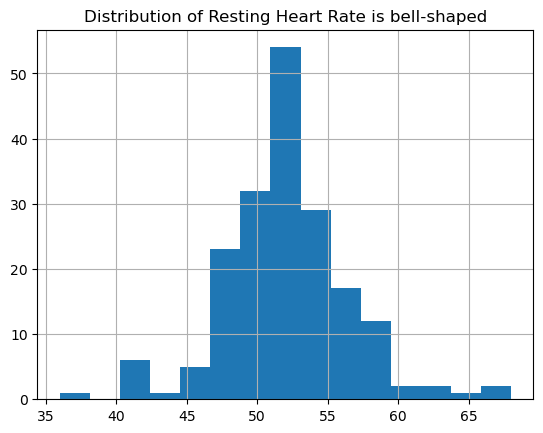

In [256]:
subset.RestingHeartRate.hist(bins=15)
plt.title("Distribution of Resting Heart Rate is bell-shaped")
plt.show()

In [216]:
# regress:
import statsmodels.api as sm
import numpy as np

reg_data = subset.dropna(how="any",subset=["RestingHeartRate","off_wrist"])

y = reg_data.RestingHeartRate.values
x = reg_data.off_wrist.values

In [217]:
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()

In [218]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.082
Date:                Tue, 13 Dec 2022   Prob (F-statistic):             0.0448
Time:                        11:37:02   Log-Likelihood:                -546.71
No. Observations:                 187   AIC:                             1097.
Df Residuals:                     185   BIC:                             1104.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.4847      3.701     16.073      0.000      52.183      66.786
x1            -0.7821      0.387     -2.020      0.045      -1.546      -0.018
==============================================================================
Omnibus:                        7.529   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.609
Skew:                           0.123   Prob(JB):                      0.00183
Kurtosis:                       4.248   Cond. No.                         108.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results are negative, and significant at the 95% level.

#### Bayesian Analysis of Resting Heart Rate? (for later)

#### Heart Rate Variability?

In [233]:
reg_data = daily.copy()
reg_data["var_HeartRate_l"] = reg_data["var_HeartRate"].shift(-1).fillna(0)
reg_data["max_HeartRate_l"] = reg_data["max_HeartRate"].shift(-1)
reg_data = reg_data.dropna(how="any",subset=["var_HeartRate_l","var_HeartRate","max_HeartRate_l","RestingHeartRate","off_wrist"])

reg_data.shape

(269, 13)

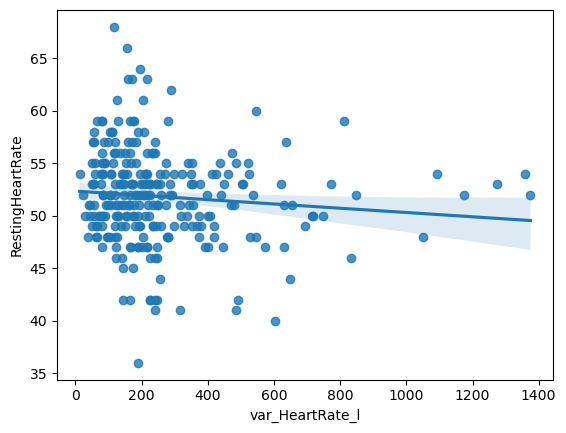

In [245]:
sns.regplot(reg_data,x="var_HeartRate_l",y="RestingHeartRate")
plt.show()

In [244]:
y = reg_data.RestingHeartRate.values
x = reg_data.var_HeartRate_l.values
x = sm.add_constant(x)
model2 = sm.OLS(y,x)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.686
Date:                Tue, 13 Dec 2022   Prob (F-statistic):              0.102
Time:                        12:05:29   Log-Likelihood:                -786.33
No. Observations:                 269   AIC:                             1577.
Df Residuals:                     267   BIC:                             1584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.3500      0.424    123.453      0.000      51.515      53.185
x1            -0.0020      0.001     -1.639      0.102      -0.004       0.000
==============================================================================
Omnibus:                        8.298   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               14.625
Skew:                           0.057   Prob(JB):                     0.000667
Kurtosis:                       4.137   Cond. No.                         525.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Type analysis

In [19]:
pp.type.value_counts()

ActiveEnergyBurned            346736
BasalEnergyBurned             207034
HeartRate                     155948
DistanceWalkingRunning        128487
StepCount                      37527
AppleExerciseTime              20615
AppleStandTime                 15991
DistanceCycling                14788
AppleStandHour                  4479
StairDescentSpeed               1647
FlightsClimbed                  1565
StairAscentSpeed                1503
HeartRateVariabilitySDNN        1257
OxygenSaturation                1199
EnvironmentalAudioExposure       969
RunningSpeed                     540
RunningPower                     484
RestingHeartRate                 332
WalkingHeartRateAverage          310
RunningVerticalOscillation       237
RunningStrideLength              236
RunningGroundContactTime         225
DistanceDownhillSnowSports       186
VO2Max                           182
RespiratoryRate                  108
SleepAnalysis                     33
LowHeartRateEvent                 31
M

### Plotting type values

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def try_cast_values_to_float(df):
    """Maps to float if possible, else np.nan to be removed by dropna after. Essentially replacing .asinstance(float) to not break whenever throws except.

    Args:
        df (_type_): _description_
    """
    def floatify(s):
        try:
            return float(s)
        except ValueError:
            return np.nan
    try:
        df.value = df.value.astype(float)
    except:
        df.value = list(filter(float.__instancecheck__, map(floatify, df.value)))
        df.dropna(subset=["value"],inplace=True)
    return df.value
    

def plot_time(data,column):
    ss = data.query("type==@column")
    ss.value = try_cast_values_to_float(ss)
    
    f = plt.figure(figsize=(16,10))
    plt.plot_date(x=ss.start,y=ss.value)
    plt.title(column)
    plt.show()

def plot_weekday(data,column,kind=None,agg_first=False, aggfunc="mean"):
    ss = data.query("type==@column")
    ss.value = try_cast_values_to_float(ss)
    
    # optional: sum for each day, then average
    if agg_first:
        ss = ss.pivot_table(index="Day",values=["value","Weekday"],aggfunc={"value":aggfunc,"Weekday":"mean"})
    else:
        pass
    
    if kind is not None:
        sns.catplot(data=ss,x="Weekday",y="value",kind=kind)
    else:
        f = plt.figure(figsize=(16,10))
        sns.boxplot(data=ss,x="Weekday",y="value")
    plt.title(column)
    plt.show()
    
def plot_hour(data,column,kind=None,agg_first=False, aggfunc="sum"):
    ss = data.query("type==@column")
    ss.value = try_cast_values_to_float(ss)

    # optional: sum for each hour, then average ! Might be biased due to unbalancing
    if agg_first:
        ss = ss.pivot_table(index=["Date","Hour"],values=["value"],aggfunc={"value":aggfunc}).reset_index()
    else:
        pass
    
    
    if kind is not None:
        sns.catplot(data=ss,x="Hour",y="value",kind=kind)
    else:
        f = plt.figure(figsize=(16,10))
        sns.boxplot(data=ss,x="Hour",y="value")
    plt.title(column)
    plt.show()


In [ ]:
# I need to add columns that give information about the heart rate measurements, when the first one was made, when the minimum was.

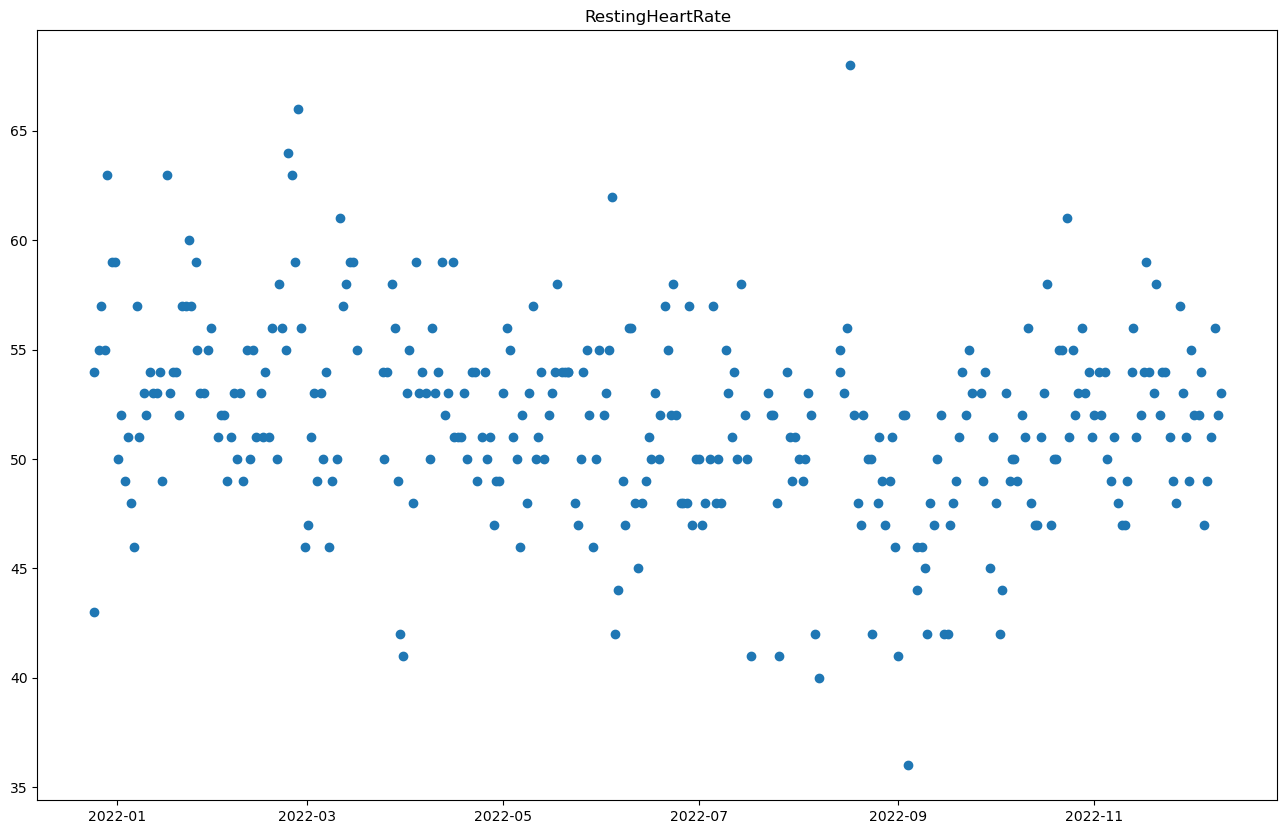

In [25]:
plot_time(pp,"RestingHeartRate")

# Analysis

## Heart Rate

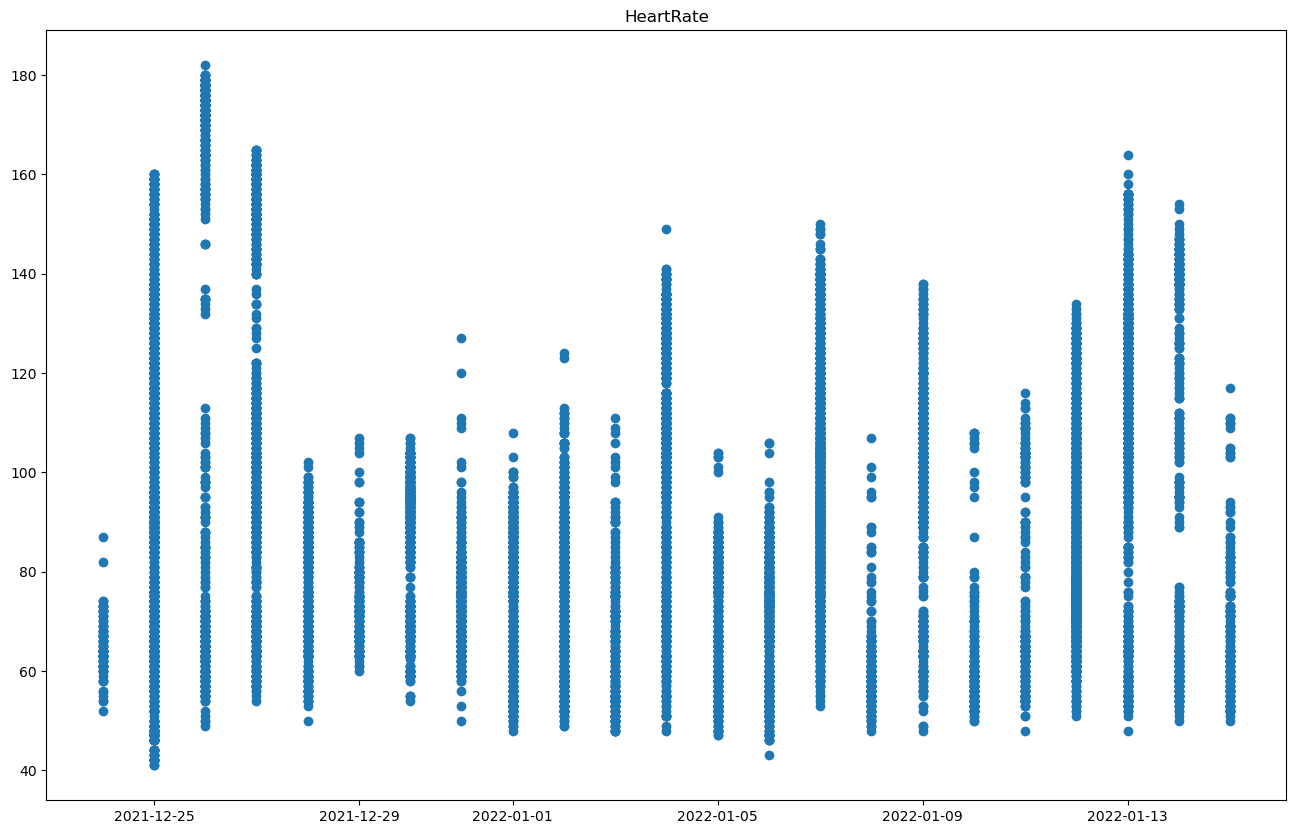

In [23]:
plot_time("HeartRate")

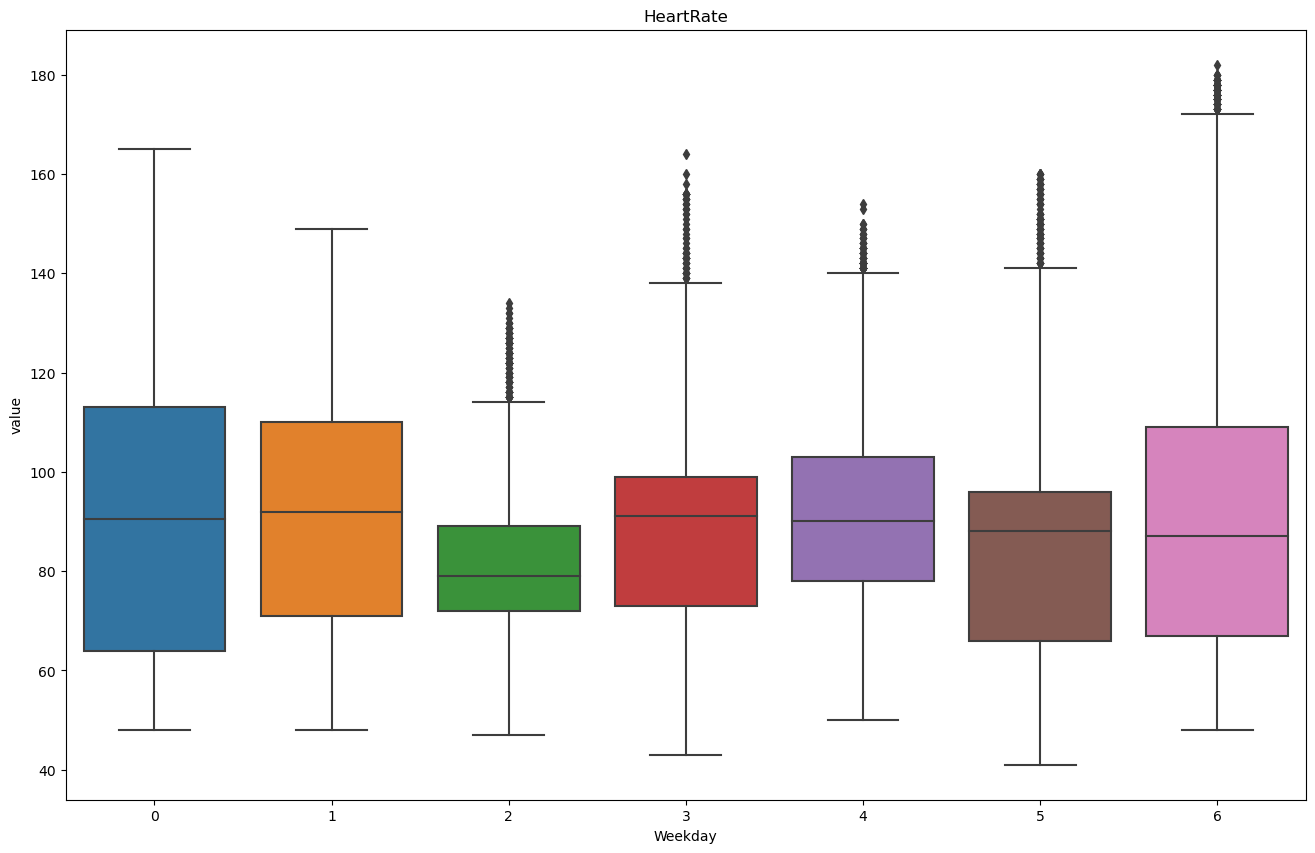

In [27]:
plot_weekday("HeartRate")

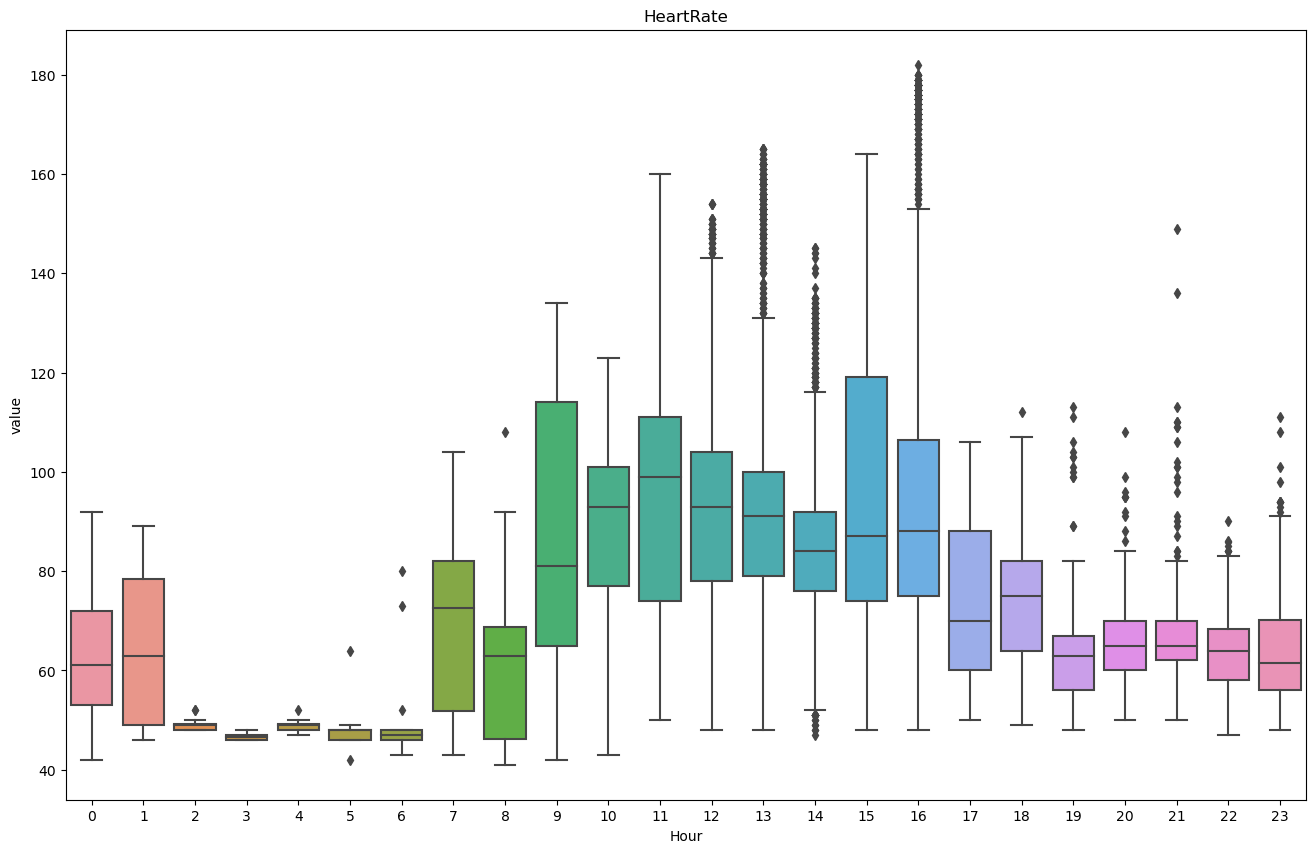

In [28]:
plot_hour("HeartRate")

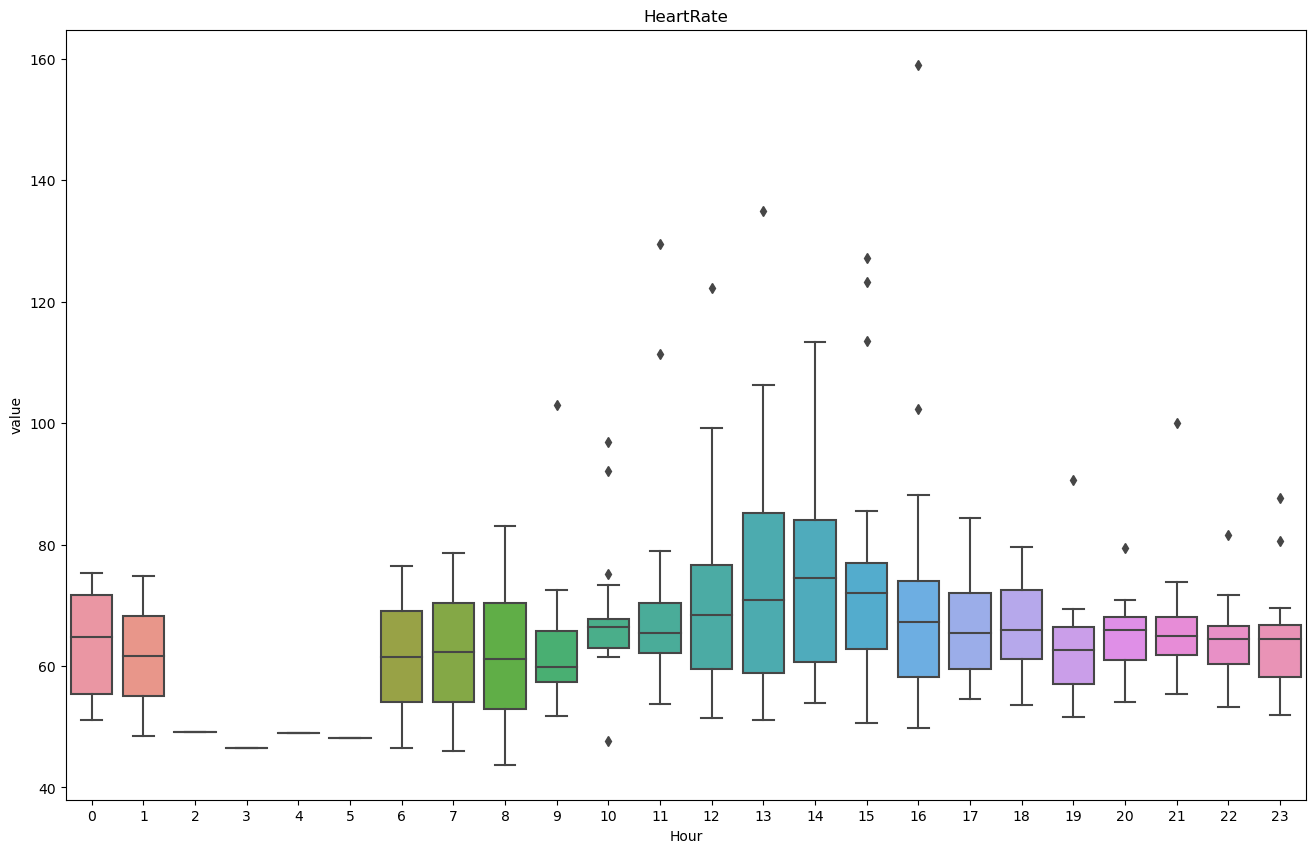

In [29]:
plot_hour("HeartRate",agg_first=True,aggfunc="mean")

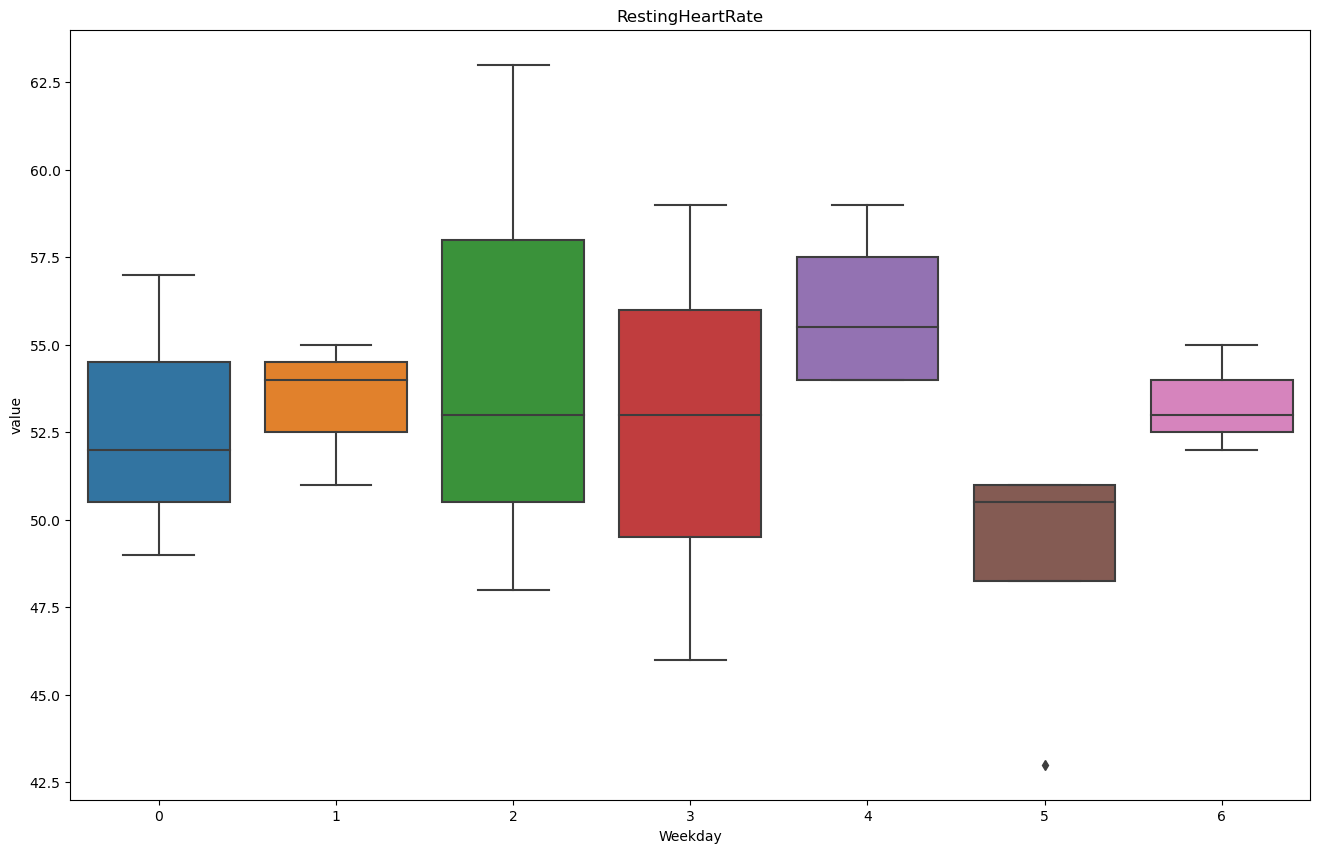

In [31]:
plot_weekday("RestingHeartRate",agg_first=True) # makes not difference if agged, since these are daily data points

## Step Count

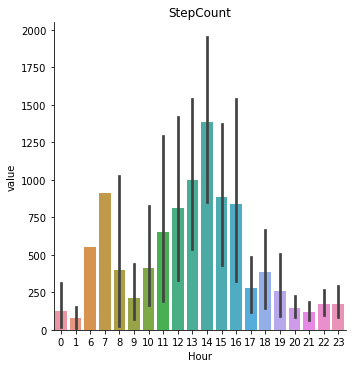

In [169]:
plot_hour("StepCount",kind="bar",agg_first=True,aggfunc="sum")

## Energy

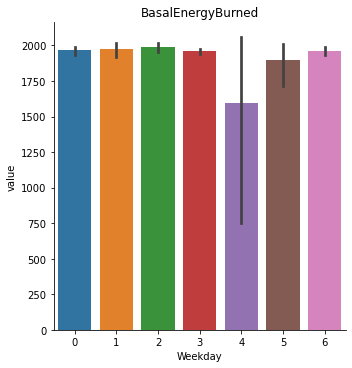

In [147]:
plot_weekday("BasalEnergyBurned",kind="bar",agg_first=True,aggfunc="sum")

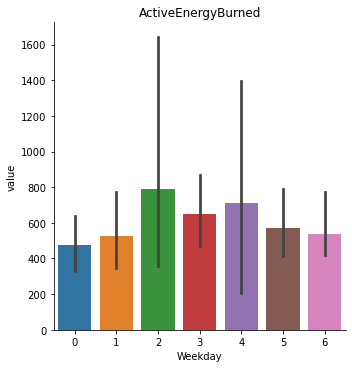

In [172]:
plot_weekday("ActiveEnergyBurned",kind="bar",agg_first=True,aggfunc="sum")

I tend to work out more on Wednesdays and Fridays - which are the days I do not have meetings.

## Distance

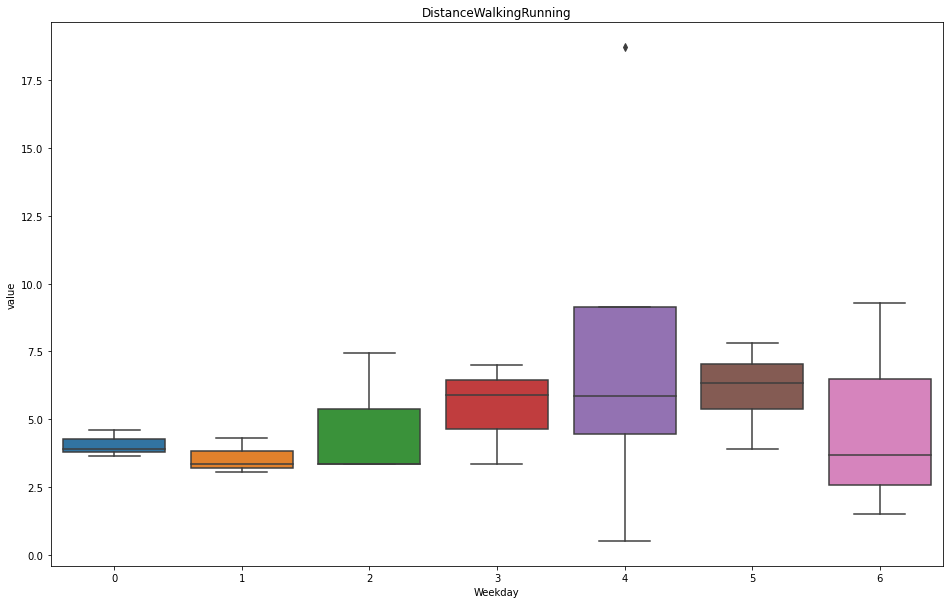

In [177]:
plot_weekday("DistanceWalkingRunning",agg_first=True,aggfunc="sum")

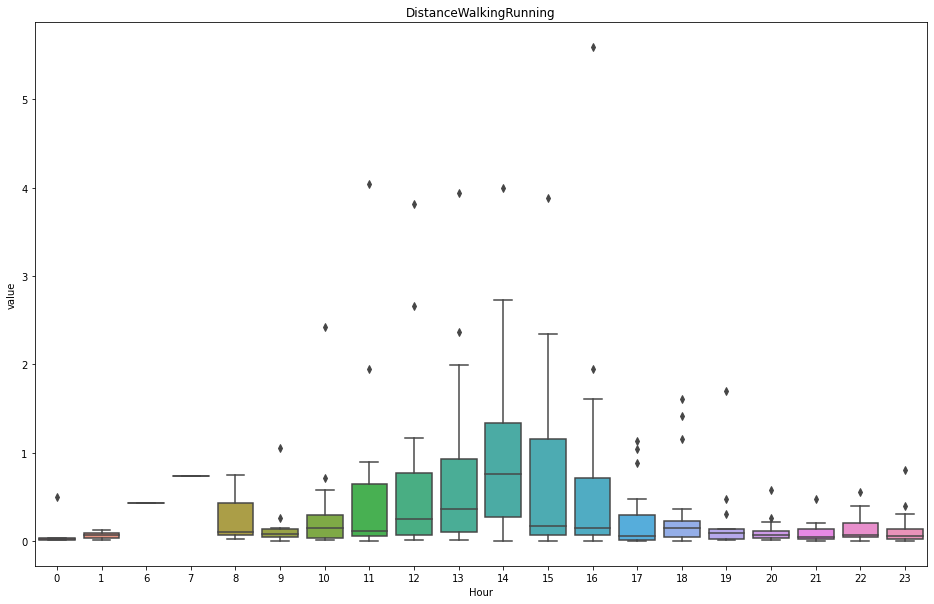

In [179]:
plot_hour("DistanceWalkingRunning",agg_first=True,aggfunc="sum")

## Apple Stand Time

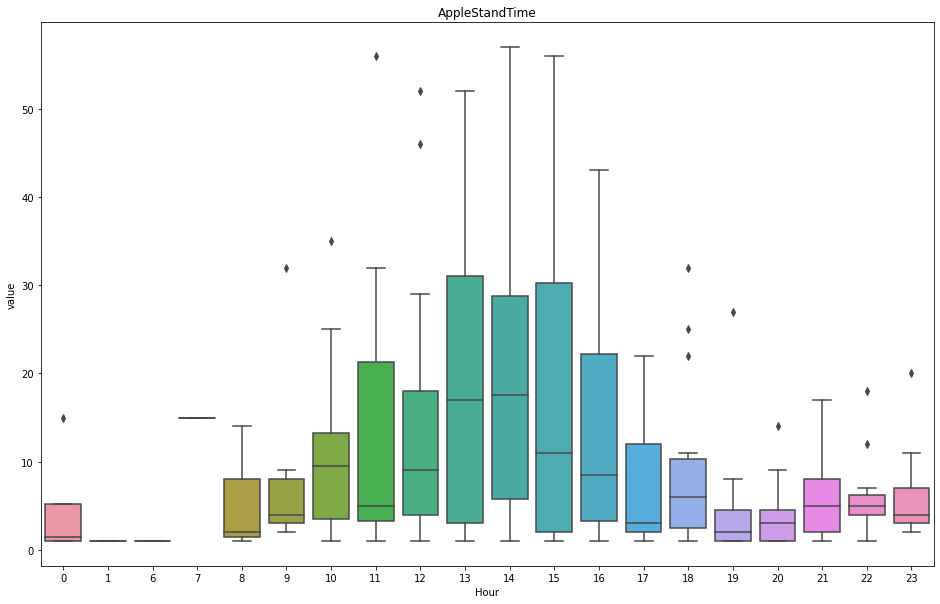

In [195]:
plot_hour("AppleStandTime",agg_first=True,aggfunc="sum")

My median standing time is below 20 minutes for all hours. I am thus sitting for approximately 90% of my waking day.